In [1]:
%cd /mnt/storage/maxenis/coptic-machine-translation

/mnt/storage/maxenis/coptic-machine-translation


In [2]:
import datasets
from transformers import AutoTokenizer
import data_utils
from huggingface_model import HuggingFaceTranslationModel
from collections import defaultdict
import json
import os
import random
from typing import Dict, List
from transformers import BertTokenizer, AutoTokenizer
import datasets
from datasets import Dataset, DatasetDict
from tqdm import tqdm
from trie import Trie
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import re
import numpy as np
from scipy.optimize import curve_fit
from typing import DefaultDict
import torch
from config_consts import *

In [4]:
def bounded_exponential(x, a, b, c):
    return a * (1 - np.exp(-b * x)) + c

def log_func(x, a, b, c):
    return a * np.log2(b*x+c)

def get_bleu(output_path):
    text = Path(output_path).read_text()
    return [float(bleu) for bleu in re.findall(r"'eval_bleu': (\d*.\d*)", text)]

def get_steps(num_rows, num_epochs = 4, step_size = 16000):
    num_steps = num_rows * num_epochs // step_size
    return [(step + 1) * step_size for step in range(num_steps)]

def plot_validation_bleu(bleu, steps, model_name, show_best_fit = False, fit_func = bounded_exponential, same_plot = False, cutoff = None):
    if cutoff:
        bleu = bleu[:cutoff]
        steps = steps[:cutoff]
    # Plotting
    if not same_plot:
        plt.figure(figsize=(10, 6))
    plt.plot(steps, bleu, marker='o', label=model_name)
    plt.title(f'{model_name} Validation BLEU over Training Steps')
    plt.xlabel('Training Steps')
    plt.ylabel('BLEU Score')
    plt.xlim((0, max(steps)))
    plt.grid(True)
    
    if show_best_fit:
        params, covariance = curve_fit(fit_func, steps, bleu, p0=[6, 1/16000, 1])
        # Generate x values for plotting the fitted curve
        x_fit = np.linspace(min(steps), max(steps), 100)
        y_fit = bounded_exponential(x_fit, *params)
        plt.plot(x_fit, y_fit, '-', label=f'{model_name} Curve')
    plt.legend()

def plot_by_len_tgt(df):
    # Plot average confidence by length of target
    df['len_tgt'] = df['tgt'].apply(lambda x: len(x.split()))
    df.groupby('len_tgt')['confidence'].mean().plot(kind='bar', figsize=(10, 6))
    plt.show()

def plot_confidence_over_epochs(df, index):
    src_entry = df.iloc[index]['src']
    filtered_df = df[df['src'] == src_entry]
    # Sort by epoch
    sorted_df = filtered_df.sort_values(by='epoch')

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_df['epoch'], sorted_df['confidence'], marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Confidence')
    plt.title(f'Confidence Over Time for src="{src_entry}"')
    plt.grid(True)
    plt.show()

def plot_into_buckets(df, granularity = 0.005):
    num_bins = int(1/granularity)
    bins = [i * granularity for i in range(num_bins+1)] 
    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(df['confidence'], bins=bins, edgecolor='black')
    plt.xlabel('Confidence Score')
    plt.ylabel('Number of Rows')
    plt.title('Distribution of Confidence Scores')
    plt.xticks(bins[::(num_bins // 20)])  # Adjust the x-ticks for better readability
    plt.show()

    bins = [i * granularity for i in range(num_bins+1)] 
    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(df['variability'], bins=bins, edgecolor='black')
    plt.xlabel('Confidence Score')
    plt.ylabel('Number of Rows')
    plt.title('Distribution of Variability Scores')
    plt.xticks(bins[::(num_bins // 20)])  # Adjust the x-ticks for better readability
    plt.show()

def extract_float(x: str):
    import re
    return float(re.search(r'\d+\.\d+', x).group())

def group_detailed_df(detailed_df, max_num_epochs=None):
    all_epochs = list(sorted(detailed_df['epoch'].unique()))
    # if max num epochs is specified, for each row, remove data after the max num epochs
    if max_num_epochs:
        all_epochs = all_epochs[:max_num_epochs]
        detailed_df = detailed_df[detailed_df['epoch'] <= all_epochs[-1]]

    grouped = detailed_df.groupby(["src", "tgt"])
    grouped = grouped.agg({"confidence": ["mean", "std"]})

    grouped = grouped.reset_index()
    grouped.columns = ['src', 'tgt', 'confidence', 'variability']
    return grouped

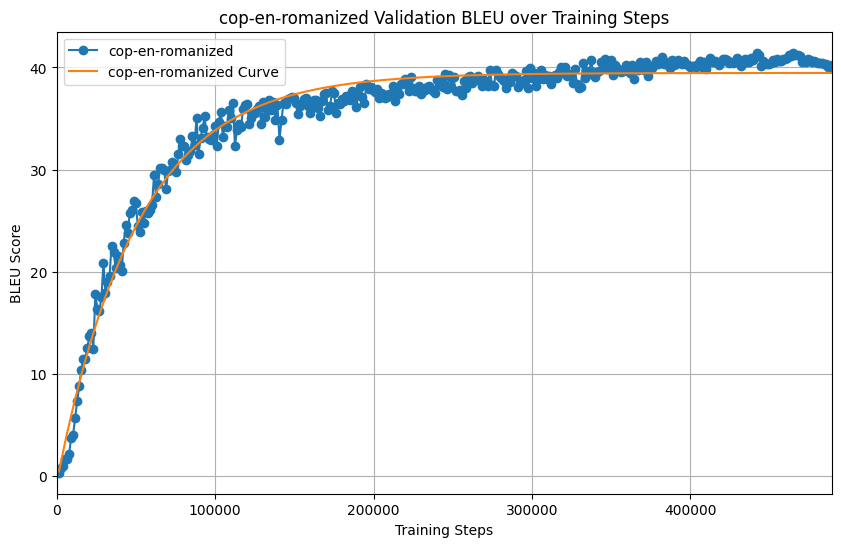

In [5]:
data = datasets.load_from_disk("datasets/cop-en-romanized")
steps = get_steps(len(data['train']), num_epochs=16, step_size=1278)
bleu  = get_bleu("logs/myoutput_2948.out")
plot_validation_bleu(bleu, steps, "cop-en-romanized", show_best_fit=True)

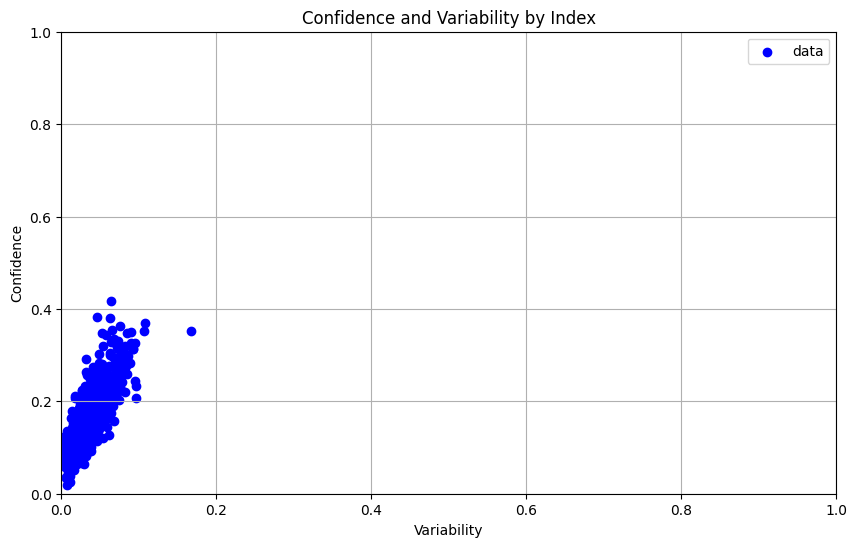

<Figure size 640x480 with 0 Axes>

In [87]:
detailed_df = pd.read_csv("models/hf/first_attempt_romanized-cop-eng/confidence.csv")
grouped = group_detailed_df(detailed_df)
data_utils.plot_dataset(grouped)

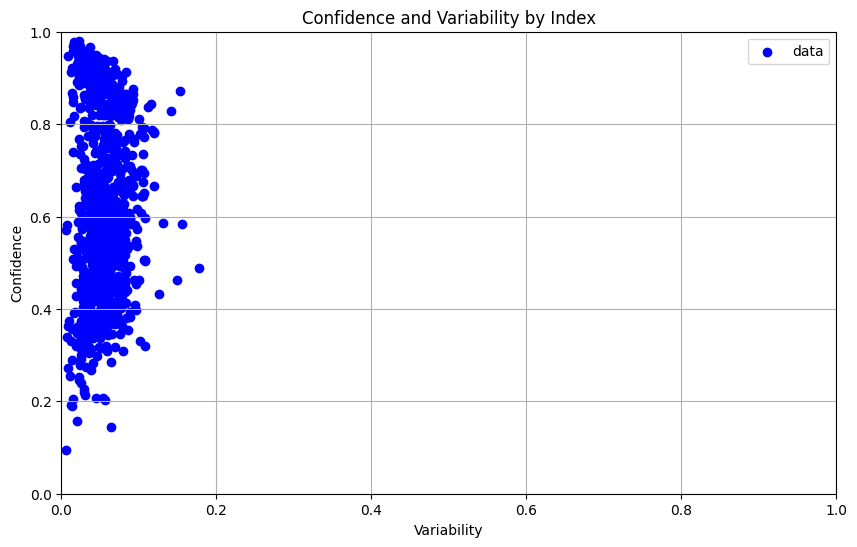

,src,tgt,confidence,variability
0,. . . . . . peie eie k shomshm . . . . . eiere...,"And thou shalt grope at mid-day, as a blind ma...",0.353639,0.032113
1,a f aheie deie eierat f nshiau peietros mn p m...,"But Peter, standing up with the eleven, lifted...",0.900876,0.061035
2,a f d hiauoouoou f n t diaukaiauosuanh n t hei...,"And he put on righteousness as a breast-plate,...",0.453458,0.070684
3,a f d na f n t arkhh mn t eieksouasiaua mn t m...,"And to him was given the dominion, and the hon...",0.624523,0.032461
4,a f d na ua mpeie toua ouaashf a f gooua n oua...,"And he gave them their request, and sent fulln...",0.555703,0.042327
...,...,...,...,...
992,… eiegn t shom m faraoou nakhaoou p rro n khme...,"FOR EGYPT, AGAINST THE POWER OF PHARAO NECHAO ...",0.350650,0.059387
993,… n seie na shooupeie eie ua neiehpeie eiero o...,They shall die of grievous death; they shall n...,0.465437,0.029073
994,………………………… ……… mmo s neief agathon,"After this the Lord looked upon the earth, and...",0.351533,0.036842
995,▢ peiega iau na f geie eieiaueie t mntsnoouas ...,"I said to him, 'As concerning the twelve hours...",0.515336,0.042720


<Figure size 640x480 with 0 Axes>

In [75]:
detailed_df = pd.read_csv("models/hf/second_attempt_romanized-finetuned-cop-eng/confidence.csv")
grouped = group_detailed_df(detailed_df, max_num_epochs=8)
data_utils.plot_dataset(grouped)
display(grouped)

In [82]:
filtered = grouped[grouped["confidence"] < .5][grouped["variability"] > 0]
display(filtered)
for i in range(min(5, len(filtered))):
    print(i)
    print(filtered.iloc[i]['src'])
    print(filtered.iloc[i]['tgt'])
...

/tmp/ipykernel_3353357/2042983523.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered = grouped[grouped["confidence"] < .5][grouped["variability"] > 0]


,src,tgt,confidence,variability
0,. . . . . . peie eie k shomshm . . . . . eiere...,"And thou shalt grope at mid-day, as a blind ma...",0.353639,0.032113
2,a f d hiauoouoou f n t diaukaiauosuanh n t hei...,"And he put on righteousness as a breast-plate,...",0.453458,0.070684
5,a f eieiau eievol hiauoouoou f . n .,He went out of him.,0.278297,0.023995
6,a f eieiau sharo iau on a f dshom na iau n t h...,and he gave unto me strength as at the first.,0.363883,0.008334
8,a f giausarks agn shiauveie .,He took upon Himself flesh without change.,0.336565,0.041490
...,...,...,...,...
988,toteie peief pneieuama na kto f n f moosheie n...,"Then shall he change his spirit, and he shall ...",0.357020,0.029768
992,… eiegn t shom m faraoou nakhaoou p rro n khme...,"FOR EGYPT, AGAINST THE POWER OF PHARAO NECHAO ...",0.350650,0.059387
993,… n seie na shooupeie eie ua neiehpeie eiero o...,They shall die of grievous death; they shall n...,0.465437,0.029073
994,………………………… ……… mmo s neief agathon,"After this the Lord looked upon the earth, and...",0.351533,0.036842


0
. . . . . . peie eie k shomshm . . . . . eiereie n theie mp . . . . . . . p kakeie . . . . . . . . . . . . . . . . . . . . . . a shooupeie hm peie ouaoeieiaush eiet mmaua eiek . . . h oua auaoou eie ua shooul mmo k n n eiehooua thr oua n f tm shooupeie nshiau p eiet na vohtheieiau eiero k
And thou shalt grope at mid-day, as a blind man would grope in the darkness, and thou shalt not prosper in thy ways; and then thou shalt be unjustly treated, and plundered continually, and there shall be no helper.
1
a f d hiauoouoou f n t diaukaiauosuanh n t heie n oua hoouk auaoou a f d eiegoou f n oua peieriaukeiefalaiaua n ouagaiau eiehraiau eiegn teief apeie auaoou a f d hiauoouoou f n oua shthn n giau kva auaoou peief rshooun
And he put on righteousness as a breast-plate, and placed the helmet of salvation on his head; and he clothed himself with the garment of vengeance, and with his cloak,
2
a f eieiau eievol hiauoouoou f . n .
He went out of him.
3
a f eieiau sharo iau on a f dshom na iau n

In [3]:
norm_model = HuggingFaceTranslationModel.from_pretrained("models/hf/fourth_attempt_romanized-norm-finetuned-cop-eng/")
norm_group_model = HuggingFaceTranslationModel.from_pretrained("models/hf/fourth_attempt_romanized-norm_group-finetuned-cop-eng/")

norm_data = datasets.load_from_disk("datasets/second-cop-en-romanized-norm")
norm_data['test'].data_dir = "datasets/second-cop-en-romanized-norm"
norm_group_data = datasets.load_from_disk("datasets/second-cop-en-romanized-norm_group")
norm_group_data['test'].data_dir = "datasets/second-cop-en-romanized-norm_group"
norm_csv = norm_model.add_translations(norm_data['test'], BEAM_GENERATION_CONFIG).to_pandas()
norm_group_csv = norm_group_model.add_translations(norm_group_data['test'], BEAM_GENERATION_CONFIG).to_pandas()


/home/bizon/anaconda3/envs/coptic/lib/python3.11/site-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


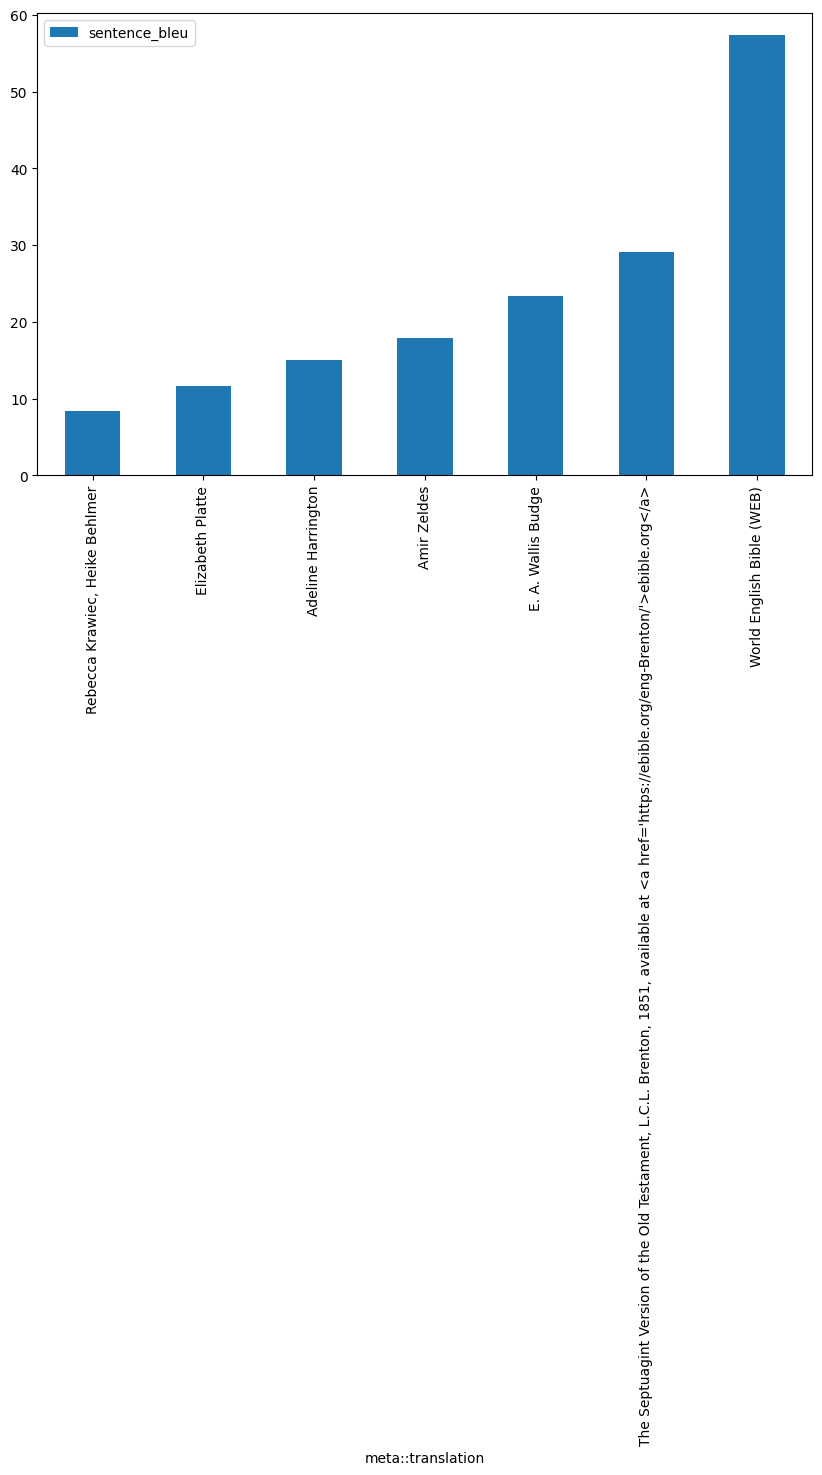

In [4]:
# filter all authors with fewer than 5 sentences
author_counts = norm_csv['meta::translation'].value_counts()
authors_to_keep = author_counts[author_counts >= 3].index
filtered_norm_csv = norm_csv[norm_csv['meta::translation'].isin(authors_to_keep)]
filtered_norm_csv[['meta::translation', 'sentence_bleu']].groupby('meta::translation').mean().sort_values('sentence_bleu').plot(kind='bar', figsize=(10, 6))
plt.show()

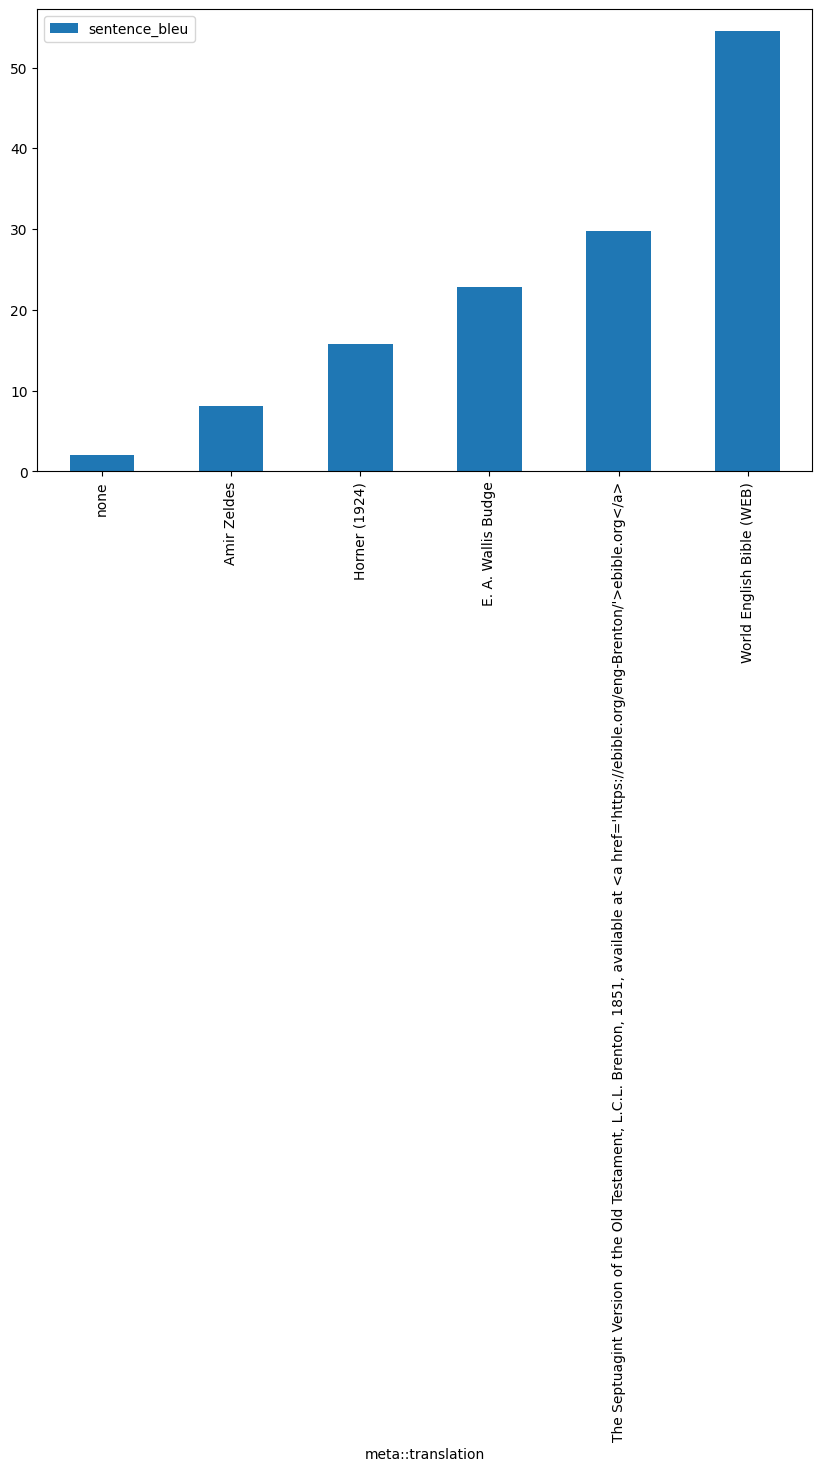

In [38]:
# filter all authors with fewer than 5 sentences
author_counts = norm_group_csv['meta::translation'].value_counts()
authors_to_keep = author_counts[author_counts >= 3].index
filtered_norm_csv = norm_group_csv[norm_group_csv['meta::translation'].isin(authors_to_keep)]
filtered_norm_csv[['meta::translation', 'sentence_bleu']].groupby('meta::translation').mean().sort_values('sentence_bleu').plot(kind='bar', figsize=(10, 6))
plt.show()

In [6]:
norm_group_csv[norm_group_csv['meta::translation'] == "Rebecca Krawiec, Heike Behlmer, Amir Zeldes" ]

,Unnamed: 0,translation,norm_group,norm,func,pos,arabic,meta::translation,meta::title,norm_romanized,norm_group_romanized,machine_translation,sentence_bleu
287,32109,"{'cop': 'alla anok aiauseietpthuatn .', 'eng':...",ⲁⲗⲗⲁ ⲁⲛⲟⲕ ⲁⲓⲥⲉⲧⲡⲧⲏⲩⲧⲛ .,ⲁⲗⲗⲁ ⲁⲛⲟⲕ ⲁ ⲓ ⲥⲉⲧⲡ ⲧⲏⲩⲧⲛ .,cc dislocated aux nsubj root obj punct,CONJ PPERI APST PPERS V PPERO PUNCT,بل أنا أخترتكم,"Rebecca Krawiec, Heike Behlmer, Amir Zeldes",Abraham Our Father XL 93-94,alla anok a iau seietp thuatn .,alla anok aiauseietpthuatn .,But I have chosen you.,100.0


In [51]:
from transformers import AutoModelForSeq2SeqLM
model = HuggingFaceTranslationModel(
    "test",
    "en",
    "en",
    tokenizer=AutoTokenizer.from_pretrained("assamim/t5-small-english"),
    model=AutoModelForSeq2SeqLM.from_pretrained("assamim/t5-small-english", from_tf=True),
    save_to_disk=False
)
model.translate("This is a test sentence.", BEAM_GENERATION_CONFIG)

Loading a TensorFlow model in PyTorch, requires both PyTorch and TensorFlow to be installed. Please see https://pytorch.org/ and https://www.tensorflow.org/install/ for installation instructions.
Loading a TensorFlow model in PyTorch, requires both PyTorch and TensorFlow to be installed. Please see https://pytorch.org/ and https://www.tensorflow.org/install/ for installation instructions.


ModuleNotFoundError: No module named 'tensorflow'

In [49]:
model.translate("And if any one deceive a virgin that is not betrothed, and lie with her, he shall surely endow her for a wife to himself", BEAM_GENERATION_CONFIG)

Both `max_new_tokens` (=128) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


'And if any one fails a virgin that is not trusted, and lie with her, he will surely end her for a wife to himself'

In [48]:
norm_csv[norm_csv["meta::title"] == "02_Exodus_22"]["translation"].iloc[0]

{'cop': 'eieshooupeie deie eiefshan tm r hna f auaoou n f tm ouaooush nshiau peies eieiauoout eie t aas na f n shiaumeie eiefeie d n oua hat m peies eieiauoout eie p shaua n teie shrhsheie n m partheienos',
 'eng': 'And if any one deceive a virgin that is not betrothed, and lie with her, he shall surely endow her for a wife to himself.'}